In [18]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer
import os


In [9]:
matrix = pd.read_csv('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/featureMatrix/3_matrix_comb.csv', index_col=0)
y_data = matrix[['BDSPPatientID', 'NoteTitle', 'annot']]

tfidf_vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1, 3), stop_words='english')
X = tfidf_vectorizer.fit_transform(matrix['text'])
# X = matrix.drop(columns=['BDSPPatientID', 'NoteDate', 'NoteTitle', 'text', 'annot'])

In [10]:
y = y_data['annot']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: annot, dtype: int64

In [11]:
all_predictions = []
all_true_labels = []
all_row_numbers = []

# outer loop
auc_cv = []
auc_pr = []
f1_cv = []
cf_cv = []
final_Cs = []
final_l1 = []
predictions = []
roc_curves = []
pr_curves = []

# Get feature names from TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Dictionary to store feature importances
feature_importances_dict = {feature: [] for feature in feature_names}

# Initialize KFold
gkf = GroupKFold(n_splits=5)

for train_index, test_index in gkf.split(X, y, groups=y_data['BDSPPatientID']):
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y.iloc[train_index], y.iloc[test_index]

    model = LogisticRegression(
        penalty='elasticnet',
        class_weight=None, random_state=2023,
        solver='saga', max_iter=10000
    )

    search_spaces = {
        'C': (1e-2, 1e+2, 'log-uniform'),
        'l1_ratio': (0.01, 0.99),
    }
    model_cv = BayesSearchCV(
        model,
        search_spaces,
        n_iter=50, scoring='roc_auc', n_jobs=15,
        cv=5, random_state=2023
    )
    model_cv.fit(Xtr, ytr)

    # Find the best hyperparameters and append them
    best_hparams = model_cv.best_params_
    best_C = best_hparams['C']
    best_l1_ratio = best_hparams['l1_ratio']
    final_Cs.append(best_C)
    final_l1.append(best_l1_ratio)

    model = model_cv.best_estimator_

    ytr_pred = model.predict_proba(Xtr)[:, 1]  # Xtr is training features, ytr is training labels, ytr_pred is training predictions = Prob(y=1|Xtr)
    yte_pred = model.predict_proba(Xte)[:, 1]  # Xte is testing features

    fpr, tpr, cutoffs = roc_curve(yte, yte_pred)
    best_cutoff = cutoffs[np.argmax(tpr - fpr)]
    yte_pred_bin = (yte_pred > best_cutoff).astype(int)
    auc_cv.append(roc_auc_score(yte, yte_pred))
    f1_cv.append(f1_score(yte, yte_pred_bin))
    cf_cv.append(confusion_matrix(yte, yte_pred_bin))
    predictions.append(yte_pred_bin)

    # Store the predictions and true labels for this fold
    all_predictions.extend(yte_pred_bin)
    all_true_labels.extend(yte)
    all_row_numbers.extend(y_data.iloc[test_index]['BDSPPatientID'])

    # Save info for the plots
    roc_curves.append((fpr, tpr, roc_auc_score(yte, yte_pred)))
    precision, recall, thresholds = precision_recall_curve(yte, yte_pred)
    pr_curves.append((recall, precision, auc(recall, precision)))
    auc_pr_loop = auc(recall, precision)
    auc_pr.append(auc_pr_loop)

    # Extract feature importances (coefficients)
    feature_importances = model.coef_[0]
    for feature, importance in zip(feature_names, feature_importances):
        feature_importances_dict[feature].append(importance)

    print("Feature importances for this fold:")
    print(pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False))

    print(auc_cv)
    print(auc_pr)

Feature importances for this fold:
          Feature  Importance
408           sah   24.182833
438  subarachnoid   14.860620
53       aneurysm   10.906496
200     hemorrhag    6.169905
92         cerebr    5.907781
..            ...         ...
80          brain   -3.458778
203       histori   -3.726659
134          deni   -3.898295
155            ed   -5.109579
180       fractur  -19.781687

[500 rows x 2 columns]
[0.958703973260014]
[0.8512177380711398]
Feature importances for this fold:
          Feature  Importance
408           sah   22.292155
438  subarachnoid   17.072199
53       aneurysm   11.494858
189          goal    5.693073
92         cerebr    5.356036
..            ...         ...
127         daili   -3.772621
94          chest   -3.829858
43           acut   -3.956127
171        famili   -4.512723
180       fractur  -12.155069

[500 rows x 2 columns]
[0.958703973260014, 0.939095449500555]
[0.8512177380711398, 0.89332603200136]
Feature importances for this fold:
        

In [5]:
print(np.mean(auc_cv))
print(np.mean(auc_pr))


0.9502214363073171
0.8575776710998062


Directory created successfully or already exists: /home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/TfidVec_stopWords_BI_MGH
Feature importances CSV saved successfully: /home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/TfidVec_stopWords_BI_MGH/feat_importances.csv


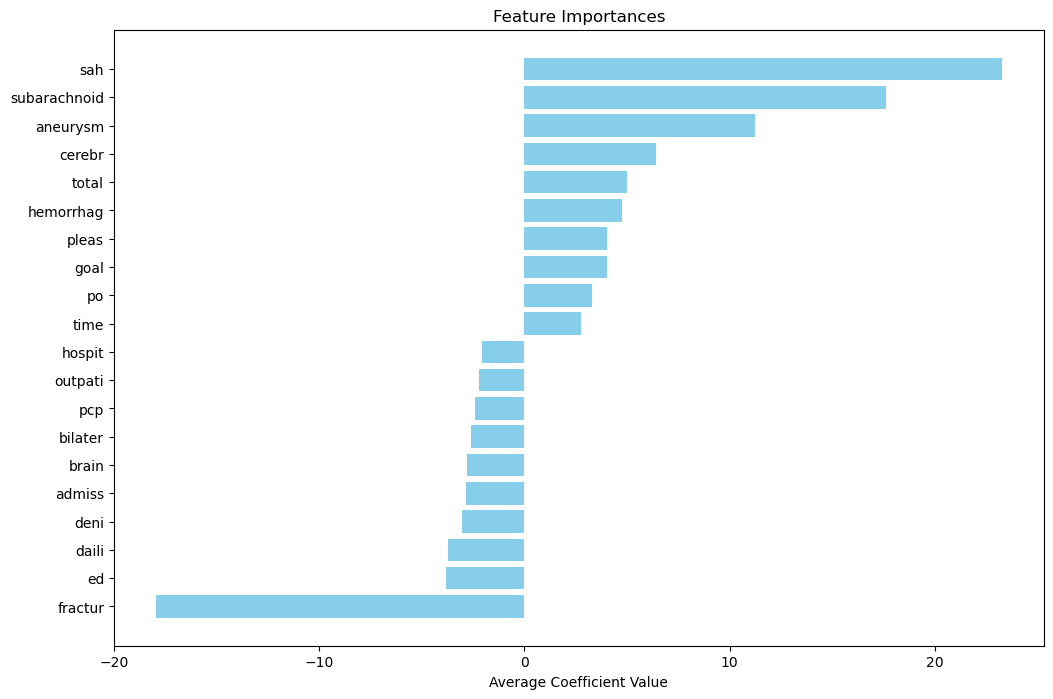

<Figure size 640x480 with 0 Axes>

In [13]:
# Aggregate feature importances by averaging over folds
avg_feature_importances = {feature: np.mean(importances) for feature, importances in feature_importances_dict.items()}
sorted_features = sorted(avg_feature_importances.items(), key=lambda item: item[1], reverse=True)
features, importances = zip(*sorted_features)

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Define the output directory
output_dir = '/home/jsearle/bigDrive/NAX/NLP-SAH_identification/model/results/TfidVec_stopWords_BI_MGH'

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the DataFrame to a CSV file
csv_file_path = os.path.join(output_dir, 'feat_importances.csv')
feature_importance_df.to_csv(csv_file_path, index=False)


# Select top 10 and bottom 10 features
top_features = features[:10]
top_importances = importances[:10]
bottom_features = features[-10:]
bottom_importances = importances[-10:]

# Combine top and bottom features for plotting
plot_features = top_features + bottom_features
plot_importances = top_importances + bottom_importances

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='skyblue')
plt.xlabel('Average Coefficient Value')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

# Save the plot to a PNG file
plt.savefig(os.path.join(output_dir, 'feat_importances.png'))

In [16]:
print(importances)

(23.26466255102679, 17.648299240020414, 11.249126910655253, 6.41060572638257, 5.023697687728736, 4.73571500600339, 4.0428001811750445, 4.011330548865011, 3.283804350975223, 2.75301447367224, 2.70872493873839, 2.274903719055602, 2.271710593233416, 2.1774494950923997, 2.035009577246665, 1.8526452747471276, 1.7694991963878615, 1.6494822293328557, 1.5867899275667718, 1.5417074785854434, 1.4928397489244638, 1.4067330929509887, 1.2675150450175512, 1.211149274304959, 1.2084219853213765, 0.8697994938289682, 0.8560797394659865, 0.8110135926357336, 0.8072024472735985, 0.672754750195774, 0.6465520697487827, 0.6320434805257852, 0.6291069268352365, 0.5160097413555425, 0.4934189947864088, 0.44732299026537703, 0.43203245578199156, 0.39075136217501444, 0.3644332812299561, 0.34145739807408443, 0.3375507168967949, 0.3241670140365306, 0.31158060045665326, 0.3096608257939829, 0.2930461450043829, 0.28620708636607634, 0.2857142086215134, 0.25392186149274387, 0.24927025494566335, 0.20975152456226892, 0.20892

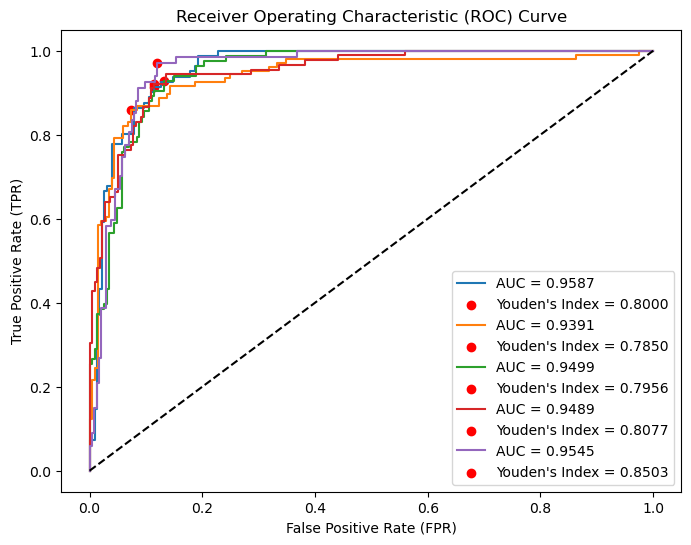

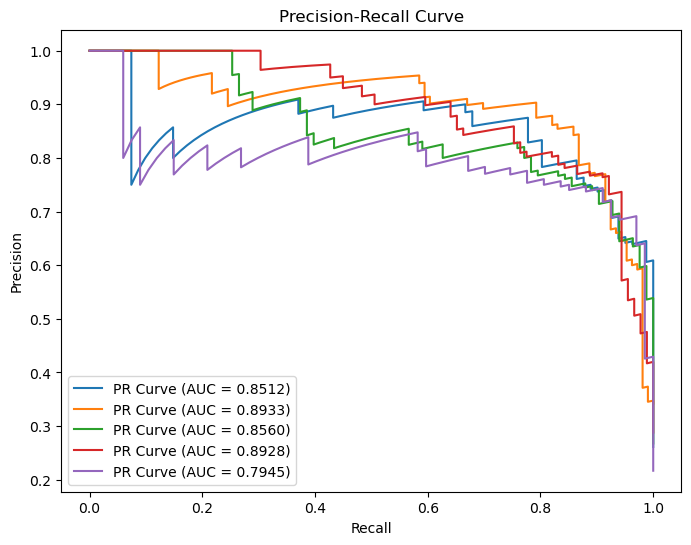

0.9502214363073171
0.8198387429667051


In [15]:
# Plot all ROC curves overlayed on a single graph
plt.figure(figsize=(8, 6))
for fpr, tpr, auc_score in roc_curves:
    plt.plot(fpr, tpr, label='AUC = {:.4f}'.format(auc_score))
    youden = np.max(tpr-fpr)
    plt.scatter(fpr[np.argmax(tpr-fpr)], tpr[np.argmax(tpr-fpr)], c='red', label=f'Youden\'s Index = {youden:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig(os.path.join(output_dir, 'AUC_iter.png'))
plt.show()

# Plot all PR curves overlayed on a single graph
plt.figure(figsize=(8, 6))
for recall, precision, auc_pr_loop in pr_curves:
    plt.plot(recall, precision, label='PR Curve (AUC = {:.4f})'.format(auc_pr_loop))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig(os.path.join(output_dir, 'PR_iter.png'))
plt.show()


# Create a DataFrame to hold the results
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction': all_predictions})

# Save the DataFrame to a CSV file
results_df.to_csv(os.path.join(output_dir, 'LR_iter_pred_rr.csv'), index=False)

# Calculate the final AUC and F1
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)

# Save all the data
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
df['C'] = final_Cs
df['l1_ratio'] = final_l1
df_pred = pd.DataFrame()
df1 = pd.DataFrame(predictions[0])
df2 = pd.DataFrame(predictions[1])
df3 = pd.DataFrame(predictions[2])
df4 = pd.DataFrame(predictions[3])
df5 = pd.DataFrame(predictions[4])
df_pred = pd.concat([df1,df2,df3,df4,df5]).reset_index()
df.to_csv(os.path.join(output_dir, 'LR_iter.csv'))

# Print final Data
print(auc_final)
print(f1_final)

In [17]:
print(final_Cs)
print(final_l1)

[2.9519282916909777, 1.8538682707459182, 2.544512921278542, 2.2724495143909054, 2.2451450432529603]
[0.9554839151043224, 0.99, 0.99, 0.99, 0.99]


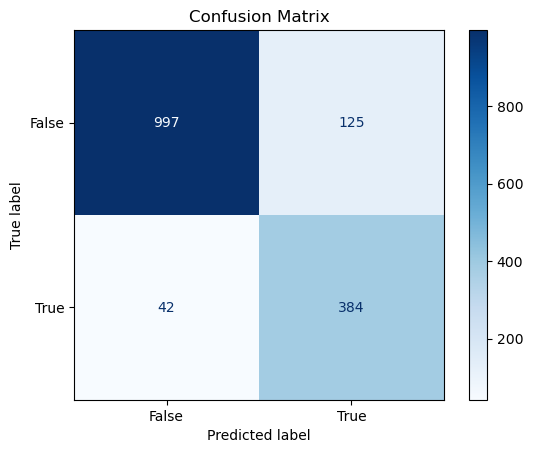

[[997 125]
 [ 42 384]]


In [19]:
# Create the confusion matrix
cf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=[False, True])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig(os.path.join(output_dir, 'cf_matrix.png'))
plt.show()

# Print the confusion matrix
print(cf_matrix)